<a href="https://colab.research.google.com/github/celestialcactus/DynamicMixer/blob/master/SentimentModel_Evaluation_SYF_Access.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports/Dependencies
First section imports all required libraries/dependencies for the workflow.

In [48]:
! pip install -U accelerate
! pip install -U transformers
! pip install -U evaluate

In [49]:
! pip install datasets transformers huggingface_hub
! pip install tiktoken

In [50]:
import transformers

## Importing Transformers
This projects workflow will be using the Transformers library:

https://huggingface.co/docs/transformers/index




Importing your model
In the below sections code, the training dataset and Language Model are imported and intitialized.

In our case, we are using distilbert-base-uncased, which is a "distilled version of the BERT base model.

The data is pretrained on the same data as BERT. " BookCorpus"

Book Corpus
https://yknzhu.wixsite.com/mbweb

https://arxiv.org/abs/1910.01108
https://huggingface.co/distilbert-base-uncased

In [51]:
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import accelerate
import torch
torch.cuda.is_available()
import datasets
from datasets import load_dataset
import numpy as np
import evaluate
from evaluate import load
from datasets import load_metric, list_metrics
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding

## Assign model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")
transformers.__version__, accelerate.__version__
d_set = load_dataset("imdb")

# Train Data Set
https://huggingface.co/transformers/v4.8.2/training.html

Fine tuning a pretrained model.



In [52]:
small_train_dataset = d_set["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = d_set["test"].shuffle(seed=42).select([i for i in list(range(300))])

## Compute Metrics Function
Compute metrics initializes the metrics which we want to evaluate the LLM's outputs with and then prints out their values.

Below, I have defined a few metrics. Accuracy and F1, along with glue and mrpc.

In [81]:
#define the evaluation metrics which we want to output
## below in this case, we output some generic evaluation metrics
## f1 is commented out because there is a runtime error using hugging faces f1 metric listed on their repo
def compute_metrics(eval_pred):
  load_accuracy = evaluate.load("accuracy")
  load_f1 = evaluate.load("f1")
  load_super_glue_metric = load('super_glue', 'copa')



  logits, labels = eval_pred
  predictions = np.argmax(logits, axis =-1)
  accuracy = load_accuracy.compute(predictions=predictions, references = labels)["accuracy"]
  f1 = load_f1.compute(predictions=predictions, references = labels)["f1"]
  super_glue = load_super_glue_metric.compute(predictions=predictions, references = labels)
  return {"accuracy":accuracy, 'f1':f1, 'super_glue':super_glue}

# Tokenization/Preprocessing
Tokenization is a sort of preprocessing done on the inputs for the model. It breaks down sentences into sub-strings which can then be processed by the model. Each word or substring then receives an id or 'token' which makes the data more readable.

We are using the transformers tokenizer from hugging face, but there are other open source libraries which can be used.


https://huggingface.co/docs/transformers/main_classes/tokenizer



In [72]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [73]:
def preprocess_function(examples):
  return tokenizer(examples["text"], truncation = True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

## Notebook Login Token
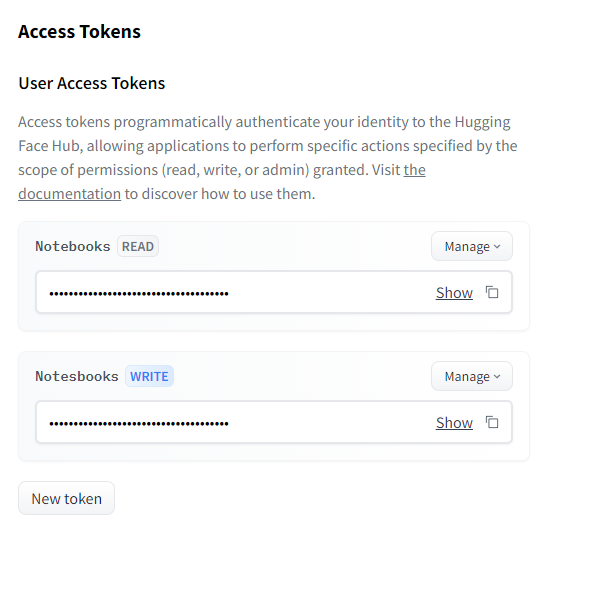

In [78]:
from huggingface_hub import notebook_login
notebook_login()

# Training/Evaluation
First, we define the repo name to output to. This will be the repo which we have defined in our huggingface notebook. You can learn about how to create a hugging face notebook here:



In [82]:
#define the repo from which to output to. This should be the notebook which we imported using the token stored in the notebook file.
## See
repo_name = "distilbert-base-uncased"

#define our directory
training_args = TrainingArguments(
   output_dir="distilbert-base-uncased",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

#instantiates our trainer
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [58]:
#This call will perform our fine tuning.
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=376, training_loss=0.06886607535341953, metrics={'train_runtime': 316.9775, 'train_samples_per_second': 18.929, 'train_steps_per_second': 1.186, 'total_flos': 782725021021056.0, 'train_loss': 0.06886607535341953, 'epoch': 2.0})

# Evaluation
This project uses the hugging face evaluate libarary. This library is a useful open source libary which enables the evaluation of Machine Learning models and datasets.

You can read more about the library here on their website for tutorials and documentation.

In our case. We are using the Evaluate library with the Transformers ML framework.

https://huggingface.co/docs/evaluate/index

You can find more about choosing the right evaluation metrics as well on this page:
https://huggingface.co/docs/evaluate/choosing_a_metric




## Evaluation Cards
Evaluation cards are like modules which you can import into project file to use with the evaluations library. You can find commonly used evaluation metrics like SuperGlue here. There's also other metric cards like Code Eval, which use the HumanEvals metric that measure a models performance on code generation related tasks.

In this project, only generaic evaluation metrics were used. However, other evaluation modules can be imported into the project and run the same way the generic metrics are run below.

Another page which desciribes how to load other evaluation modules into evaluate:
https://huggingface.co/docs/evaluate/creating_and_sharing

List of hugging-face evaluation cards:
https://huggingface.co/evaluate-metric

Specific Code evaluation card:
https://huggingface.co/spaces/evaluate-metric/code_eval

In [83]:
#Compute Evaluation Metrics
trainer.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.8766666666666667}" of type <class 'dict'> for key "eval/super_glue" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.643564760684967,
 'eval_accuracy': 0.8766666666666667,
 'eval_f1': 0.8794788273615636,
 'eval_super_glue': {'accuracy': 0.8766666666666667},
 'eval_runtime': 7.498,
 'eval_samples_per_second': 40.01,
 'eval_steps_per_second': 2.534}

In [84]:
#upload model to hugging face hub
trainer.push_to_hub()

events.out.tfevents.1702056176.b781954b981d.341.3:   0%|          | 0.00/346 [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1702056225.b781954b981d.341.4:   0%|          | 0.00/389 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

'https://huggingface.co/DangerRat/distilbert-base-uncased/tree/main/'